In [1]:
from abc import ABC, abstractmethod
from functools import reduce
import itertools
import operator
import pickle
import random
import re
from typing import Callable, Dict, List, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from tqdm import tqdm

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, tdim=100):
    """
    Truncate a colormap by taking a segment between minval and maxval.

    Parameters:
        cmap : matplotlib colormap
            Original colormap to be truncated.
        minval : float, default 0.0
            Minimum value to start truncating.
        maxval : float, default 1.0
            Maximum value for truncation.
        tdim : int, default 100
            Number of discrete colors to generate.

    Returns:
        new_cmap : matplotlib colormap
            The truncated colormap.
    """
    truncated_name = f"trunc({cmap.name},{minval:.2f},{maxval:.2f})"
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        truncated_name,
        cmap(np.linspace(minval, maxval, tdim))
    )
    return new_cmap


def calc_norm_limits(low, high):
    """
    Calculate normalized limits for color mapping.

    The function scales the input values so that the maximum absolute value is normalized
    to 1, then adjusts the range to [0, 1].

    Parameters:
        low : float
            Lower bound value.
        high : float
            Upper bound value.

    Returns:
        norm_low, norm_high : tuple of floats
            Normalized lower and upper limits.
    """
    # Ensure that low is no more than 0 and high is no less than 0
    low = min(low, 0)
    high = max(high, 0)

    # Normalize by the maximum absolute value
    scale_factor = max(abs(np.array([low, high])))
    norm_low = low / scale_factor
    norm_high = high / scale_factor

    # Shift and scale to [0, 1]
    norm_low = norm_low / 2 + 0.5
    norm_high = norm_high / 2 + 0.5

    return norm_low, norm_high


def pltimshow(imshowdata, vmin=None, vmax=None, fig=None, ax=None, **kwargs):
    """
    Display an image using imshow with a truncated colormap and an attached colorbar.

    Parameters:
        imshowdata : array-like
            Image data to be displayed.
        vmin : float, optional
            Minimum data value for colormap scaling.
        vmax : float, optional
            Maximum data value for colormap scaling.
        fig : matplotlib Figure, optional
            Figure object; required if ax is provided.
        ax : matplotlib Axes, optional
            Axes object on which to draw the image.
        **kwargs : dict
            Additional keyword arguments passed to plt.imshow() or ax.imshow().
    """
    # Mask invalid values in the image data
    imshowdata = np.ma.masked_invalid(imshowdata)

    # Set color scaling if not provided
    if vmax is None:
        vmax = np.max(imshowdata)
    if vmin is None:
        vmin = np.min(imshowdata)

    # Calculate normalized limits for the colormap
    norm_low, norm_high = calc_norm_limits(vmin, vmax)

    # Get and truncate the colormap
    cmap = mpl.colormaps.get_cmap("PiYG").copy()
    cmap = truncate_colormap(cmap, norm_low, norm_high, tdim=100)
    cmap.set_bad(color='black')

    if ax is None:
        plt.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        plt.colorbar()
    else:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='10%', pad=0.15)
        im = ax.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        fig.colorbar(im, cax=cax, orientation='vertical')


In [3]:
def plot_chunked_lines(vectors, labels, chunk_names, figsize=(10, 6), title=None):
    """
    Plots multiple vectors on a single plot divided into chunks,
    with only horizontal grid lines and no x-axis tick marks.

    Parameters
    ----------
    vectors : list of array-like
        List of 1D sequences, all of the same length.
    labels : list of str
        Labels for each vector in `vectors`.
    chunk_names : list of str
        Names for each chunk; data is evenly divided into len(chunk_names) chunks.
    figsize : tuple (optional)
        Figure size in inches (width, height).
    """
    vectors = [np.asarray(vec) for vec in vectors]
    length = vectors[0].shape[0]
    num_chunks = len(chunk_names)
    if length % num_chunks != 0:
        raise ValueError("Length of vectors must be divisible by number of chunks")
    chunk_size = length // num_chunks
    x = np.arange(length)

    plt.figure(figsize=figsize)
    for vec, lbl in zip(vectors, labels):
        plt.plot(x, vec, label=lbl)
        plt.fill_between(x, vec)

    # Only horizontal grid lines
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Draw only the vertical dividing lines
    for i in range(1, num_chunks):
        plt.axvline(x=i * chunk_size - 1, color='gray', linestyle='--', linewidth=1)

    # Center chunk labels, hide tick marks but keep labels
    centers = [(i + 0.5) * chunk_size for i in range(num_chunks)]
    plt.xticks(centers, chunk_names)
    plt.tick_params(axis='x', which='both', length=0)

    plt.xlim(0,len(vectors[0]))

    #plt.xlabel("Chunks")
    #plt.ylabel("Value")
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def plot_stacked_arrays(arrays, row_labels=None, titles=None):
    """
    Plot multiple 2D numpy arrays as vertically stacked subplots.

    Parameters
    ----------
    arrays : list of ndarray, each shape (R, W)
        The binary (0/1) arrays to plot; may contain NaNs.
    row_labels : list of str, length R, optional
        Labels for the rows (shared across all subplots).
    titles : list of str, length len(arrays), optional
        Titles for each subplot.
    """
    n = len(arrays)
    if n == 0:
        raise ValueError("Need at least one array to plot.")

    # validate shapes
    R, W = arrays[0].shape
    for arr in arrays:
        if arr.shape != (R, W):
            raise ValueError("All arrays must have the same shape (R, W).")

    # default row labels
    if row_labels is None:
        row_labels = [str(i) for i in range(R)]
    elif len(row_labels) != R:
        raise ValueError(f"row_labels must be length {R}")

    # default titles
    if titles is not None and len(titles) != n:
        raise ValueError(f"titles must be length {n}")

    # reversed column labels
    col_labels = [str(W-1-i) for i in range(W)]

    # make figure
    fig, axes = plt.subplots(nrows=n, ncols=1, sharex=True,
                             figsize=(max(4, W*0.4), n * max(2, R*0.2)))
    if n == 1:
        axes = [axes]

    # colormap for 0/1
    bin_cmap = ListedColormap(['white', 'black'])

    for idx, arr in enumerate(arrays):
        ax = axes[idx]

        # show 0/1
        im = ax.imshow(arr,
                       cmap=bin_cmap,
                       interpolation='nearest',
                       origin='upper',
                       vmin=0, vmax=1)

        # overlay NaN hatch
        nan_mask = np.isnan(arr)
        for (i, j), is_nan in np.ndenumerate(nan_mask):
            if is_nan:
                rect = Rectangle((j-0.5, i-0.5), 1, 1,
                                 facecolor='gray',
                                 edgecolor='gray',
                                 hatch='///',
                                 linewidth=0)
                ax.add_patch(rect)

        # row labels
        ax.set_yticks(np.arange(R))
        ax.set_yticklabels(row_labels)

        # only bottom plot gets x-labels
        if idx == n-1:
            ax.set_xticks(np.arange(W))
            ax.set_xticklabels(col_labels)
            ax.set_xlabel("bit position")
        else:
            ax.set_xticks([])

        # title if given
        if titles:
            ax.set_title(titles[idx])

    plt.tight_layout()
    plt.show()


# constructing linear system pt. 1

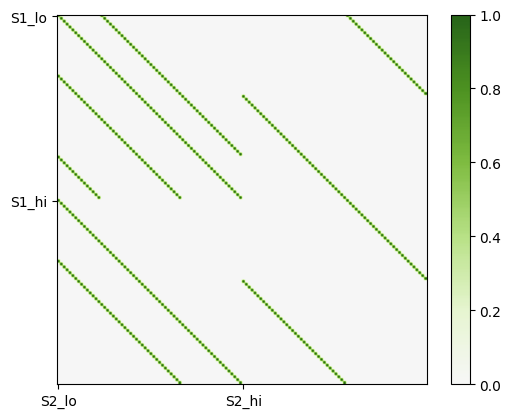

In [5]:
state_transition_matrix = np.load('state_matrix_regular.npz')['state_matrix']
pltimshow(state_transition_matrix)
plt.yticks([0,64],['S1_lo','S1_hi'],)
plt.xticks([0,64],['S2_lo','S2_hi'],);

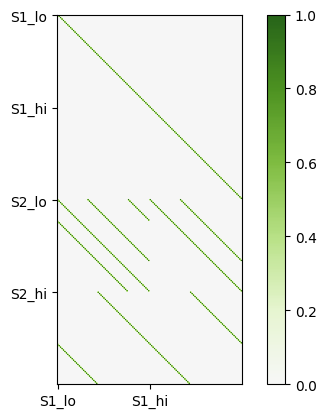

In [6]:
firststate_basisvects = np.eye(128)
secondstate_basisvects = (state_transition_matrix @ firststate_basisvects.T).T%2
bothstate_basisvects = np.vstack([firststate_basisvects,secondstate_basisvects])

pltimshow(bothstate_basisvects)
plt.yticks(np.arange(4)*64,['S1_lo','S1_hi','S2_lo','S2_hi'],)
plt.xticks([0,64],['S1_lo','S1_hi'],);

In [7]:
# create all row and column variables
# row variables = all variables
# col variables = a reduced set of variables such that all row vars are linear funcs of col vars

roworder = [
    'S1_lo',
    'S1_hi',
    'S2_lo',
    'S2_hi',
    'S1_ca',
    'S1_is',
    'S1_cb',
    'S1_out',
    'S2_ca',
    'S2_is',
    'S2_cb',
    'S2_out',
]
colorder = ['S1_lo','S1_hi','S1_ca','S1_cb','S2_ca','S2_cb',]

rowvars = []
for prefix in roworder:
    rowvars.extend([f'{prefix}_{x:02d}' for x in range(63,-1,-1)])

colvars = []
for prefix in colorder:
    colvars.extend([f'{prefix}_{x:02d}' for x in range(63,-1,-1)])

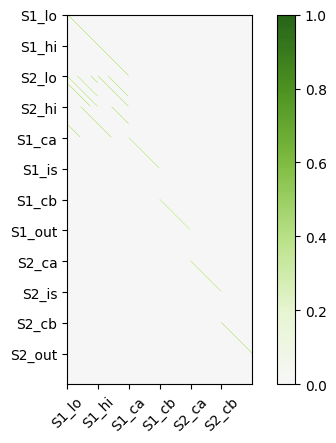

In [8]:
# construct the linear system matrix and begin filling it it

fullsystem = np.zeros((len(rowvars),len(colvars)))

fullsystem[:bothstate_basisvects.shape[0],:bothstate_basisvects.shape[1]] = bothstate_basisvects

for rowidx,rowvar in enumerate(rowvars):
    for colidx,colvar in enumerate(colvars):
        if rowvar == colvar:
            fullsystem[rowidx,colidx] = 1

pltimshow(fullsystem)
plt.yticks(np.arange(len(roworder))*64,roworder)
plt.xticks(np.arange(len(colorder))*64,colorder, rotation=45);

# creating list of operations from additions

In [9]:
class Operation(ABC):
    """
    Abstract base class for mathematical operations on named variables.
    Subclasses must implement the compute method and provide an operator_symbol.
    """
    def __init__(self, output_name: str, input_names: list[str]):
        if not isinstance(output_name, str):
            raise TypeError("output_name must be a string")
        if not all(isinstance(n, str) for n in input_names):
            raise TypeError("input_names must be a list of strings")
        self.output_name = output_name
        self.input_names = list(input_names)

    @property
    @abstractmethod
    def operator_symbol(self) -> str:
        """Symbol representing the operation, e.g. '+', '^'."""
        pass

    def __str__(self) -> str:
        """
        Human-readable representation: output = in1 OP in2 OP in3 ...
        """
        joined = f" {self.operator_symbol} ".join(self.input_names)
        return f"{self.output_name} = {joined}"

    @abstractmethod
    def compute(self, *args):
        """
        Perform the core calculation on the input values.
        """
        pass

    def apply(self, labels: list[str], values):
        """
        Apply the operation:
          - labels: list of variable names.
          - values: list or numpy array of corresponding values.

        Validates inputs (no None or NaN) and that output is unset (None or NaN),
        computes result, and returns a new list/array with output updated.
        """
        # Build name -> index map
        name_to_idx = {name: idx for idx, name in enumerate(labels)}
        # Ensure required names present
        for name in self.input_names + [self.output_name]:
            if name not in name_to_idx:
                raise ValueError(f"Variable '{name}' not found in labels")

        input_indices = [name_to_idx[n] for n in self.input_names]
        output_idx = name_to_idx[self.output_name]
        # Gather input values
        input_values = [values[i] for i in input_indices]
        # Validate input values
        for val, name in zip(input_values, self.input_names):
            if val is None or (isinstance(val, float) and np.isnan(val)):
                raise ValueError(f"Input variable '{name}' has invalid value: {val}")
        # Validate output unset
        current_out = values[output_idx]
        if not (current_out is None or (isinstance(current_out, float) and np.isnan(current_out))):
            raise ValueError(f"Output '{self.output_name}' already set to: {current_out}")
        # Compute result
        result = self.compute(*input_values)
        # Prepare new values container
        if isinstance(values, np.ndarray):
            new_vals = values.copy()
        else:
            new_vals = list(values)
        new_vals[output_idx] = result
        return new_vals

    def can_apply(self, labels: list[str], values) -> bool:
        """
        Check if the operation can be applied without modifying data.
        Returns True if apply() succeeds, False if it raises an error.
        """
        try:
            self.apply(labels, values)
            return True
        except Exception:
            return False

    def with_affixes(self, prefix: str = "", suffix: str = ""):
        """
        Return a new operation of the same type with prefixed/suffixed variable names.

        :param prefix: String to prepend to each variable name.
        :param suffix: String to append to each variable name.
        :return: New Operation instance with modified output and input names.
        """
        new_output = f"{prefix}{self.output_name}{suffix}"
        new_inputs = [f"{prefix}{name}{suffix}" for name in self.input_names]
        return type(self)(new_output, new_inputs)

class XOROperation(Operation):
    """
    Bitwise XOR operation on binary inputs (0 or 1).
    Accepts any number of inputs >= 1.
    """
    @property
    def operator_symbol(self) -> str:
        return '^'

    def __init__(self, output_name: str, input_names: list[str]):
        if len(input_names) < 1:
            raise ValueError("XOROperation requires at least one input variable")
        super().__init__(output_name, input_names)

    def compute(self, *args):
        # Convert inputs to int and XOR
        bits = [int(arg) for arg in args]
        return reduce(operator.xor, bits)

class CarryOperation(Operation):
    """
    Carry operation on binary inputs (0 or 1).
    Output is 1 if two or more inputs are 1; otherwise 0.
    Accepts exactly two or three input variables.
    """
    @property
    def operator_symbol(self) -> str:
        return '&' if len(self.input_names) == 2 else '|'  # placeholder

    def __init__(self, output_name: str, input_names: list[str]):
        if len(input_names) not in (2, 3):
            raise ValueError("CarryOperation requires two or three input variables")
        super().__init__(output_name, input_names)

    def __str__(self) -> str:
        if len(self.input_names) == 2:
            a, b = self.input_names
            return f"{self.output_name} = {a} & {b}"
        else:
            a, b, c = self.input_names
            # return (f"{self.output_name} = ({a} & {b}) | ({b} & {c}) | ({a} & {c})")
            return (f"{self.output_name} = carry({a}, {b}, {c})")

    def compute(self, *args):
        # Convert inputs to int and validate binary
        bits = [int(arg) for arg in args]
        for bit, name in zip(bits, self.input_names):
            if bit not in (0, 1):
                raise ValueError(f"Input variable '{name}' must be 0 or 1, got {bit}")
        # Carry if two or more bits are 1
        return 1 if sum(bits) >= 2 else 0

In [10]:
# variable symbols

syms_lo = [f'lo_{x:02d}' for x in range(64)]
syms_hi = [f'hi_{x:02d}' for x in range(64)]
syms_ca = [f'ca_{x:02d}' for x in range(64)]
syms_is = [f'is_{x:02d}' for x in range(64)]
syms_cb = [f'cb_{x:02d}' for x in range(64)]
syms_out = [f'out_{x:02d}' for x in range(64)]

syms_is_rot = syms_is[47:] + syms_is[:47]

In [11]:
firstadd_linearlist = []
firstadd_nonlinearlist = []
for i in range(64):
    addend1 = syms_lo[i]
    addend2 = syms_hi[i]
    carryin = syms_ca[i-1]
    carryout = syms_ca[i]
    result = syms_is[i]


    if i == 0:
        firstadd_linearlist.append((result,addend1,addend2))
        firstadd_nonlinearlist.append((carryout,addend1,addend2))
    else:
        firstadd_linearlist.append((result,carryin,addend1,addend2))
        firstadd_nonlinearlist.append((carryout,carryin,addend1,addend2))

secondadd_linearlist = []
secondadd_nonlinearlist = []
for i in range(64):
    addend1 = syms_is_rot[i]
    addend2 = syms_lo[i]
    carryin = syms_cb[i-1]
    carryout = syms_cb[i]
    result = syms_out[i]


    if i == 0:
        secondadd_linearlist.append((result,addend1,addend2))
        secondadd_nonlinearlist.append((carryout,addend1,addend2))
    else:
        
        secondadd_linearlist.append((result,carryin,addend1,addend2))
        secondadd_nonlinearlist.append((carryout,carryin,addend1,addend2))

# full linear system

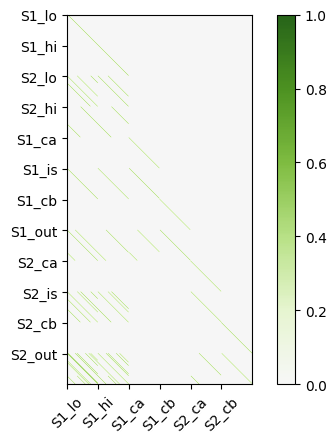

In [12]:
linearlist = firstadd_linearlist + secondadd_linearlist

for S in ['S1','S2']:
    for tup in linearlist:
        yvar = f'{S}_' + tup[0]
        xvars = [f'{S}_' + x for x in tup[1:]]
        yidx = rowvars.index(yvar)
        assert fullsystem[yidx].sum() == 0, print(tup)
        for xvar in xvars:
            xidx = rowvars.index(xvar)
            assert fullsystem[xidx].sum() != 0, print(xvar,tup)
            fullsystem[yidx] = np.logical_xor(fullsystem[yidx],fullsystem[xidx])

pltimshow(fullsystem)
plt.yticks(np.arange(len(roworder))*64,roworder)
plt.xticks(np.arange(len(colorder))*64,colorder, rotation=45);

# nonlinear operations: matrix and list form

In [13]:
def tuples_to_one_and_multi_hot(
    data: List[Tuple[str, ...]],
    classes: List[str]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a list of tuples of strings into:
      1) A one-hot array for the first element of each tuple.
      2) A multi-hot array for the remaining elements of each tuple.

    Parameters
    ----------
    data : List[Tuple[str, ...]]
        List of R tuples, each containing one or more strings.
    classes : List[str]
        List of W unique strings (the universe of possible values),
        in the order defining the columns.

    Returns
    -------
    first_one_hot : np.ndarray, shape (R, W)
        first_one_hot[i, j] = 1 if classes[j] == data[i][0], else 0.
    rest_multi_hot : np.ndarray, shape (R, W)
        rest_multi_hot[i, j] = 1 if classes[j] appears in data[i][1:], else 0.
    """
    R = len(data)
    W = len(classes)

    # Map each class string to its column index
    idx_map = {cls: idx for idx, cls in enumerate(classes)}

    # Initialize zero arrays
    first_one_hot = np.zeros((R, W), dtype=int)
    rest_multi_hot = np.zeros((R, W), dtype=int)

    for i, tpl in enumerate(data):
        if not tpl:
            # skip empty tuple if any
            continue

        # one-hot for the first element
        first = tpl[0]
        j = idx_map.get(first)
        if j is not None:
            first_one_hot[i, j] = 1
        else:
            raise ValueError(f"Unknown class '{first}' in tuple #{i}")

        # multi-hot for the rest
        for other in tpl[1:]:
            j = idx_map.get(other)
            if j is not None:
                rest_multi_hot[i, j] = 1
            else:
                raise ValueError(f"Unknown class '{other}' in tuple #{i}")

    return first_one_hot, rest_multi_hot


In [14]:
nonlinearlist = firstadd_nonlinearlist + secondadd_nonlinearlist

all_carry_tuples = []
for S in ['S1','S2']:
    for tup in nonlinearlist:
        all_carry_tuples.append(tuple(f'{S}_{x}' for x in tup))

In [15]:
consequents, antecedents = tuples_to_one_and_multi_hot(all_carry_tuples, rowvars)

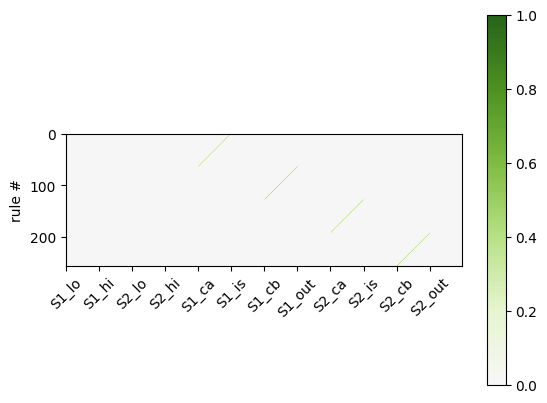

In [16]:
pltimshow(consequents)
plt.ylabel('rule #')
plt.xticks(np.arange(len(roworder))*64,roworder, rotation=45);

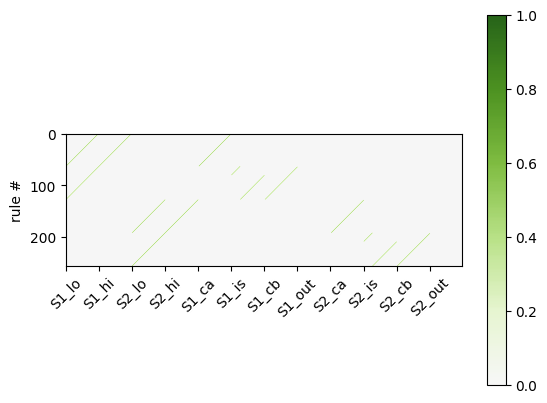

In [17]:
pltimshow(antecedents)
plt.ylabel('rule #')
plt.xticks(np.arange(len(roworder))*64,roworder, rotation=45);

In [18]:
nonlinear_oplist = []
for tup in all_carry_tuples:
    yvar = tup[0]
    xvars = tup[1:]
    nonlinear_oplist.append(CarryOperation(yvar,xvars))

# client config creation example

array([640, 128])

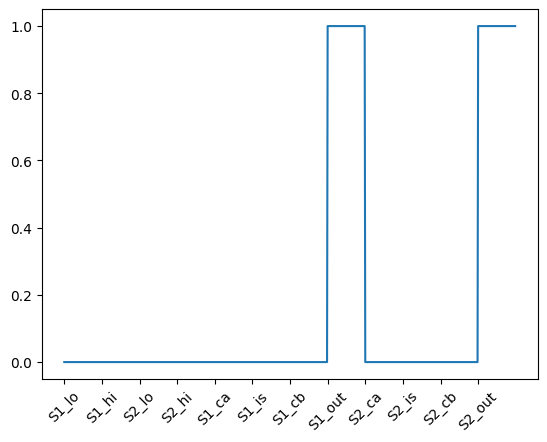

In [19]:
# describe which groups of variables should be initialized separately

init_labels = np.zeros(len(rowvars),dtype='int')

blocknum = roworder.index('S1_out')
init_labels[blocknum*64:(blocknum+1)*64] = 1

blocknum = roworder.index('S2_out')
init_labels[blocknum*64:(blocknum+1)*64] = 1

plt.plot(init_labels)
plt.xticks(np.arange(len(roworder))*64,roworder, rotation=45);

np.bincount(init_labels)

In [20]:
# tell client to randomly initialize 128/128 of output vars and 64/640 of other vars

init_counts = np.array([64,128])

array([128, 640])

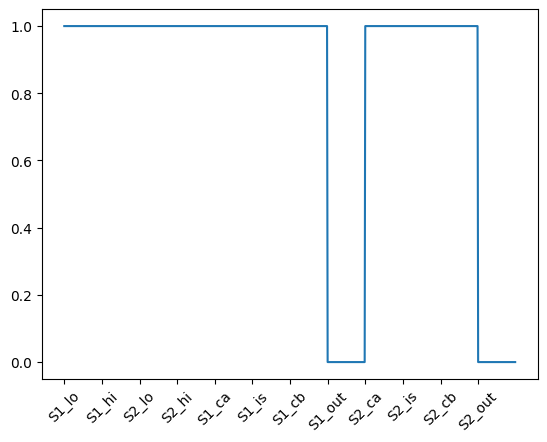

In [21]:
# describe which groups of variables should be optimized separately
# 0 = do not optimize

swap_labels = np.ones(len(rowvars),dtype='int')

blocknum = roworder.index('S1_out')
swap_labels[blocknum*64:(blocknum+1)*64] = 0

blocknum = roworder.index('S2_out')
swap_labels[blocknum*64:(blocknum+1)*64] = 0

plt.plot(swap_labels)
plt.xticks(np.arange(len(roworder))*64,roworder, rotation=45);

np.bincount(swap_labels)

array([640, 128])

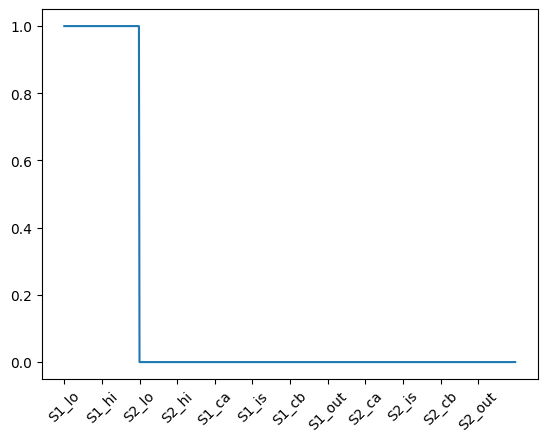

In [22]:
# describe which groups of variables we want to solve for

target_mask = np.zeros(len(rowvars),dtype='int')

blocknum = roworder.index('S1_lo')
target_mask[blocknum*64:(blocknum+1)*64] = 1

blocknum = roworder.index('S1_hi')
target_mask[blocknum*64:(blocknum+1)*64] = 1

plt.plot(target_mask)
plt.xticks(np.arange(len(roworder))*64,roworder, rotation=45);

np.bincount(target_mask)

In [23]:
# write config

# np.savez("config-001-from2nextlongs-rand64-int32.npz",
#          fullsystem=fullsystem.astype(bool),
#          antecedents=antecedents.astype(bool),
#          consequents=consequents.astype(bool),
#          init_labels=init_labels.astype(np.int32),
#          init_counts=init_counts.astype(np.int32),
#          swap_labels=swap_labels.astype(np.int32),
#          target_mask=target_mask.astype(np.int32),
#         )

# verify solution (how the client does it)

In [24]:
def hex_to_binary_array(hex_string):
    """
    Convert a hex string to a numpy array of binary values (0s and 1s).

    Parameters:
        hex_string (str): A string of hexadecimal digits. Can optionally start with '0x'.

    Returns:
        np.ndarray: 1-D array of uint8 0s and 1s representing the binary bits.
    """
    # Remove optional '0x' or '0X' prefix
    if hex_string.startswith(('0x', '0X')):
        hex_string = hex_string[2:]

    # Validate input
    valid_chars = set('0123456789abcdefABCDEF')
    if any(c not in valid_chars for c in hex_string):
        raise ValueError(f"Invalid hex string: {hex_string}")

    # Convert each hex digit to 4 bits
    bits = []
    for char in hex_string:
        val = int(char, 16)
        # Format as 4-bit binary string, e.g., '0110'
        b = format(val, '04b')
        bits.extend(int(bit) for bit in b)

    return np.array(bits, dtype=np.uint8)

In [25]:
def gf2_dependent_subset(sel, M):
    """
    Single-pass GF(2) rank + dependency detection with micro-optimizations:
      * Use argmax to find pivots.
      * Minimize per-loop overhead.
      * Process selected rows first, then candidate rows.

    Parameters
    ----------
    sel : boolean array of shape (n,)
        Indicator for which rows are selected.
    M   : boolean array of shape (n, c)
        GF(2) matrix.

    Returns
    -------
    rank_val : int
        Rank of the submatrix formed by selected rows.
    dep : boolean array of shape (n,)
        For each row k not selected (sel[k]==False), dep[k] == True if that row
        is in the span of the selected rows.
    """
    # Ensure boolean arrays
    sel = np.asarray(sel, dtype=bool)
    M   = np.asarray(M,   dtype=bool)
    n   = M.shape[0]

    # Indices of selected and candidate rows
    sel_idx  = np.flatnonzero(sel)
    cand_idx = np.flatnonzero(~sel)
    num_sel  = sel_idx.size
    num_cand = cand_idx.size

    # If no rows selected, rank is 0 and no dependencies
    if num_sel == 0:
        return 0, np.zeros(n, dtype=bool)

    # Build top block: selected rows of M
    A = M[sel_idx, :]
    top_count = A.shape[0]

    # Build bottom block: candidate rows of M (empty if none)
    C = M[cand_idx, :] if num_cand > 0 else np.zeros((0, M.shape[1]), dtype=bool)
    bottom_count = C.shape[0]

    # Combine blocks into one matrix for elimination
    B = np.vstack((A, C))
    row_count, col_count = B.shape

    # Perform Gaussian elimination over GF(2)
    pivot_row = 0
    for col in range(col_count):
        if pivot_row >= top_count:
            break

        subcol = B[pivot_row:top_count, col]
        pivot_offset = subcol.argmax()
        if not subcol[pivot_offset]:
            continue

        pivot_idx = pivot_row + pivot_offset
        if pivot_idx != pivot_row:
            B[[pivot_row, pivot_idx]] = B[[pivot_idx, pivot_row]]

        # Eliminate 1s below the pivot in this column
        if pivot_row < row_count - 1:
            below = B[pivot_row + 1:, col]
            rows_to_xor = np.flatnonzero(below) + (pivot_row + 1)
            if rows_to_xor.size > 0:
                B[rows_to_xor] ^= B[pivot_row]

        pivot_row += 1

    rank_val = pivot_row

    # Determine which candidate rows are in the span (zero rows after elimination)
    dep = np.zeros(n, dtype=bool)
    if bottom_count > 0 and rank_val > 0:
        candidate_block = B[top_count:]
        dep_mask = ~candidate_block.any(axis=1)
        dep[cand_idx[dep_mask]] = True

    return rank_val, dep

In [26]:
def infer_new_vars(V: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Given:
        V: 1D binary array of length W (known vars marked 1)
        X: 2D binary array of shape (R, W) (rule antecedents)
        Y: 2D binary array of shape (R, W) (rule consequents)

    Returns:
        A binary vector of length W containing newly inferred vars:
          - For each rule i, if all X[i,j]==1 ⇒ V[j]==1, the rule is 'satisfied'.
          - OR together all Y[i] for satisfied rules.
          - Zero out any positions already 1 in V.
    """
    # 1) Check antecedents: rule i is satisfied if X[i] <= V elementwise
    #    i.e. wherever X[i]==1, V must also be 1.
    #    (X & ~V) will be 1 where X demands a var that V doesn't know; so we want no such bits.
    violated = (X & (~V.astype(bool))).any(axis=1)
    satisfied = ~violated

    # 2) Build binary vector of satisfied rules (optional to return if needed)
    #    sat_vec = satisfied.astype(int)

    # 3) OR together the consequents Y for satisfied rules
    if satisfied.any():
        or_result = np.any(Y[satisfied], axis=0)
    else:
        or_result = np.zeros_like(V, dtype=bool)

    # 4) Zero out positions already known in V
    new_inferences = or_result & (~V.astype(bool))

    # 5) Return as int array
    return new_inferences.astype(int)


In [27]:
def fill_known_symbols(curvect):

    curvect = curvect.copy()
    
    pastlinear = 0
    curlinear = curvect.sum()

    pastnonlinear = 0
    curnonlinear = curvect.sum()

    while pastlinear != curlinear or pastnonlinear != curnonlinear:
        if pastlinear != curlinear:
            rank,infervect = gf2_dependent_subset(curvect,fullsystem)
            curvect = np.maximum(curvect,infervect)

            pastlinear = curlinear
            curlinear = curvect.sum()
            curnonlinear = curvect.sum()
            pastlinear = curlinear # since linear never needs to be run twice in a row
            
        if pastnonlinear != curnonlinear:
            infervect = infer_new_vars(curvect,antecedents,consequents)
            curvect = np.maximum(curvect,infervect)

            pastnonlinear = curnonlinear
            curlinear = curvect.sum()
            curnonlinear = curvect.sum()
            
    return curvect 

In [28]:
solutionstring = '00080000000800000000801200000002000401830000800014002a0000051001000040002000500080068008800040010000000000000000ffffffffffffffff000000010000400000010000000400000002000080004000ffffffffffffffff'

In [29]:
bestvect = hex_to_binary_array(solutionstring)

In [30]:
# 128/128 output vars and 40/640 other vars
np.bincount(swap_labels,bestvect)

array([128.,  40.])

In [31]:
filledbest = fill_known_symbols(bestvect)

In [32]:
# all target bits found
assert (filledbest * target_mask).sum() == 128

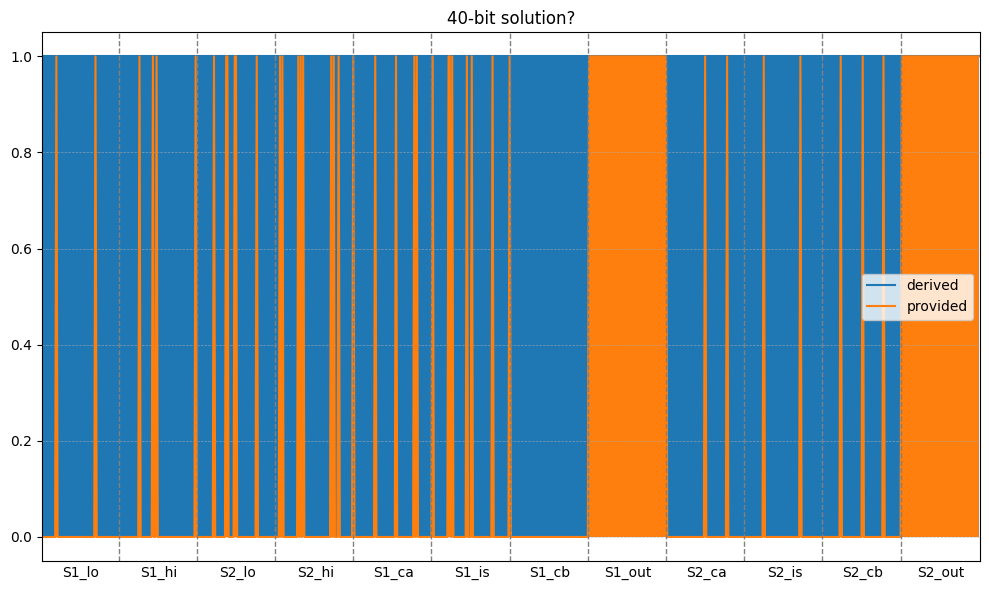

In [33]:
plot_chunked_lines(
    [filledbest,bestvect], 
    ['derived','provided'], 
    roworder, 
    title=f'{int(bestvect.sum() - 64*2)}-bit solution?'
)

# construct algorithm list of operations

In [34]:
# ----------------------------------------------------------------------------- 
# Helper utilities – kept internal to avoid polluting the user namespace
# -----------------------------------------------------------------------------
def _bool_to_int(arr: np.ndarray) -> int:
    """Pack a 1-D bool array into a python int (LSB = arr[0])."""
    out = 0
    for i, bit in enumerate(arr):
        if bit:
            out |= 1 << i
    return out


def _int_to_bool(n: int, length: int) -> np.ndarray:
    """Convert python int back to a bool array of fixed length."""
    return np.fromiter(((n >> i) & 1 for i in range(length)),
                       count=length, dtype=bool)


def _greedy_descent(seed: int, seed_w: int, basis_ints: List[int]) -> (int, int):
    """Simple 1-vector flip descent until no single flip helps."""
    current, best_w = seed, seed_w
    improved = True
    while improved:
        improved = False
        for vec in basis_ints:
            cand = current ^ vec
            w = cand.bit_count()
            if w < best_w:
                current, best_w = cand, w
                improved = True
    return current, best_w

def _min_weight_rep(c0_int: int,
                    basis_ints: List[int],
                    exhaustive_limit: int = 24,
                    pair_limit: int = 50,
                    n_restarts: int = 3,
                    restart_flips: int = 2
                   ) -> int:
    """
    Find a low-weight vector in the coset c0_int ⊕ span(basis_ints).
    * Exact Gray-code when dim ≤ exhaustive_limit.
    * Otherwise:
       1) Greedy single-flip descent.
       2) Pairwise swaps among the `pair_limit` lightest basis vectors.
       3) `n_restarts` of random-perturb + greedy.
    """
    null_dim = len(basis_ints)
    # trivial/exact branch
    if null_dim <= exhaustive_limit:
        best = c0_int
        best_w = best.bit_count()
        combo = 0
        prev_gray = 0
        for g in range(1, 1 << null_dim):
            gray = g ^ (g >> 1)
            flip = gray ^ prev_gray
            bit = (flip & -flip).bit_length() - 1
            combo ^= basis_ints[bit]
            prev_gray = gray
            cand = c0_int ^ combo
            w = cand.bit_count()
            if w < best_w:
                best, best_w = cand, w
                if best_w == 0:
                    break
        return best

    # 1) Greedy descent from c0_int
    best = current = c0_int
    best_w = current.bit_count()
    current, w0 = _greedy_descent(current, best_w, basis_ints)
    if w0 < best_w:
        best, best_w = current, w0

    # 2) Pairwise swap among the lightest basis vectors
    if null_dim > 1:
        # pick the pair_limit lightest basis by their own popcount
        light = sorted(basis_ints, key=lambda x: x.bit_count())[:pair_limit]
        improved = True
        while improved:
            improved = False
            for i in range(len(light)):
                for j in range(i+1, len(light)):
                    cand = best ^ light[i] ^ light[j]
                    w = cand.bit_count()
                    if w < best_w:
                        best, best_w = cand, w
                        improved = True
            # repeat until no pairwise improvement
    # 3) Random-restart greedy
    for _ in range(n_restarts):
        # seed = c0_int ⊕ random small combination of basis
        seed = c0_int
        for vec in random.sample(basis_ints, min(restart_flips, null_dim)):
            seed ^= vec
        w_seed = seed.bit_count()
        cand, w_cand = _greedy_descent(seed, w_seed, basis_ints)
        if w_cand < best_w:
            best, best_w = cand, w_cand

    return best
# -----------------------------------------------------------------------------


def dependency_info(M: np.ndarray,
                    sel: np.ndarray
                   ) -> Tuple[np.ndarray, np.ndarray, int]:
    """
    As in the original specification, but each dependent un-selected row is now
    expressed with *minimum* possible Hamming weight over the selected rows.
    """

    # ---- normalise inputs ---------------------------------------------------
    M   = np.asarray(M,   dtype=bool)
    sel = np.asarray(sel, dtype=bool)

    R, C            = M.shape
    selected_rows   = np.flatnonzero(sel)
    unselected_rows = np.flatnonzero(~sel)

    k   = selected_rows.size
    dep = np.zeros(R,  dtype=bool)          # result #1
    D   = np.zeros((R, R), dtype=bool)      # result #2
    if k == 0:
        return dep, D, 0                    # nothing selected → nothing to do

    # Identity mapping for *selected* rows
    D[selected_rows, selected_rows] = True

    # -------------------------------------------------------------------------
    # 1) Row-reduce the selected block  (same as before)
    # -------------------------------------------------------------------------
    A     = M[selected_rows].copy()         # k × C
    comb  = np.eye(k, dtype=bool)           # tracks each working row as XOR of
                                            # the original selected rows

    piv_rows, piv_cols = [], []
    row = 0
    for col in range(C):
        # locate next pivot ≥ current row
        cand = np.flatnonzero(A[row:, col]) + row
        if cand.size == 0:
            continue
        piv = cand[0]
        if piv != row:                      # swap rows to move pivot up
            A[[row, piv]]   = A[[piv, row]]
            comb[[row, piv]] = comb[[piv, row]]

        piv_rows.append(row)
        piv_cols.append(col)

        # eliminate the pivot column in *all* other rows
        mask = (np.arange(k) != row) & A[:, col]
        A[mask]    ^= A[row]
        comb[mask] ^= comb[row]
        row += 1
        if row == k:
            break

    rank_sel = row                          # independent pivots found

    # Keep only the pivot rows (already in row-echelon form)
    A_piv    = A[piv_rows]       if rank_sel else np.empty((0, C), dtype=bool)
    comb_piv = comb[piv_rows]    if rank_sel else np.empty((0, k), dtype=bool)

    # -------------------------------------------------------------------------
    # 2) Build a *row-kernel* basis of the selected block.
    #    Rows that have turned completely to 0 give us dependencies.
    # -------------------------------------------------------------------------
    nullspace_rows = comb[rank_sel:]        # shape: (k-rank_sel) × k
    basis_ints     = [_bool_to_int(row) for row in nullspace_rows]

    # -------------------------------------------------------------------------
    # 3) Test every un-selected row and store *minimal* combination.
    # -------------------------------------------------------------------------
    for idx in unselected_rows:
        v = M[idx].copy()                   # working copy of the row
        c = np.zeros(k, dtype=bool)         # coefficient vector (selected rows)

        # Gauss–Jordan back-substitution over the pivot rows
        for piv_vec, piv_col, coeff_vec in zip(A_piv, piv_cols, comb_piv):
            if v[piv_col]:
                v ^= piv_vec
                c ^= coeff_vec

        if v.any():                         # independent of the selected set
            continue

        # --- Row is dependent – make c minimal --------------------------------
        c0_int       = _bool_to_int(c)
        best_int     = _min_weight_rep(c0_int, basis_ints)
        best_bool    = _int_to_bool(best_int, k)

        dep[idx] = True
        D[idx, selected_rows] = best_bool   # write back using original order

    return dep, D, rank_sel


In [35]:
def min_row_index_with_mask(D, dep):
    """
    Returns the index of the row in D with the minimum sum where dep[idx] is True.
    Returns None if no such row exists.
    
    Parameters:
    D (list of lists or np.ndarray): The matrix.
    dep (list or np.ndarray): Boolean mask for rows.
    
    Returns:
    int or None: Index of the row with minimum sum satisfying dep condition.
    """
    D = np.asarray(D)
    dep = np.asarray(dep)

    if D.shape[0] != dep.shape[0]:
        raise ValueError("Length of dep must match number of rows in D.")

    valid_indices = np.where(dep)[0]
    if len(valid_indices) == 0:
        return None

    row_sums = D[valid_indices].sum(axis=1)
    min_idx_within_valid = np.argmin(row_sums)
    
    return valid_indices[min_idx_within_valid]

In [36]:
# functions to reformat the operations into cuda-compatible syntax

def translateVariable(s):
    prefix, suffix = s.rsplit('_', 1)
    if not suffix.isdigit():
        raise ValueError("The string must end with a numeric value after the last underscore.")
    return f"{prefix}[{int(suffix)}]"

    
# A registry of operation handlers.  
# Keys are function names in the pseudocode (e.g. "carry"),
# Values are callables that take a list of argument strings (already translated)
# and return the C++ snippet.
operation_handlers: Dict[str, Callable[[List[str]], str]] = {}

def carry_handler(args: List[str]) -> str:
    """
    Expands carry(a, b, c) into:
        (a & b) | (b & c) | (a & c)
    Assumes args are already translated variable names.
    """
    a, b, c = args
    return f"(({a} & {b}) | ({b} & {c}) | ({a} & {c}))"

# Register the carry handler
operation_handlers['carry'] = carry_handler

def translate_line_to_cuda(line: str) -> str:
    """
    Translates a single line of your pseudocode into a CUDA/C++ assignment.
    
    Steps:
      1. Parse out the LHS (destination) and RHS (expression).
      2. Use translateVariable() on the LHS.
      3. In the RHS:
         a. Replace every identifier (except 'carry') with translateVariable().
         b. Expand any registered function calls (e.g. carry) via operation_handlers.
      4. Append a semicolon and return.
    """
    # 1. Split LHS and RHS
    m = re.match(r'\s*(\w+)\s*=\s*(.+)', line)
    if not m:
        raise ValueError(f"Line does not match '<dest> = <expr>': {line!r}")
    lhs, rhs = m.group(1), m.group(2)

    # 2. Translate the destination variable
    lhs_cpp = translateVariable(lhs)

    # 3a. Translate all identifiers except the function name 'carry'
    #     (we'll expand carry next)
    def id_repl(match):
        name = match.group(1)
        return translateVariable(name)
    rhs = re.sub(r'\b(?!carry\b)([A-Za-z_]\w*)\b', id_repl, rhs)

    # 3b. Expand any registered operations (e.g. carry)
    def func_repl(match):
        func = match.group(1)
        raw_args = match.group(2)
        args = [arg.strip() for arg in raw_args.split(',')]
        if func in operation_handlers:
            return operation_handlers[func](args)
        # leave unknown functions untouched
        return match.group(0)

    # matches e.g. carry(arg1, arg2, arg3)
    rhs = re.sub(r'\b([A-Za-z_]\w*)\s*\(\s*([^)]+)\)', func_repl, rhs)

    # 4. Produce the final C++ line
    return f"{lhs_cpp} = {rhs};"


In [37]:
# list of input bits over which bruteforce is performed

counter = 0
for isguess,sym in zip(bestvect,rowvars):
    if isguess and 'out' not in sym:
        print(f'{translateVariable(sym)} = guess_bits[{counter}];')
        counter += 1

S1_lo[51] = guess_bits[0];
S1_lo[19] = guess_bits[1];
S1_hi[47] = guess_bits[2];
S1_hi[36] = guess_bits[3];
S1_hi[33] = guess_bits[4];
S1_hi[1] = guess_bits[5];
S2_lo[50] = guess_bits[6];
S2_lo[40] = guess_bits[7];
S2_lo[39] = guess_bits[8];
S2_lo[33] = guess_bits[9];
S2_lo[32] = guess_bits[10];
S2_lo[15] = guess_bits[11];
S2_hi[60] = guess_bits[12];
S2_hi[58] = guess_bits[13];
S2_hi[45] = guess_bits[14];
S2_hi[43] = guess_bits[15];
S2_hi[41] = guess_bits[16];
S2_hi[18] = guess_bits[17];
S2_hi[16] = guess_bits[18];
S2_hi[12] = guess_bits[19];
S2_hi[0] = guess_bits[20];
S1_ca[46] = guess_bits[21];
S1_ca[29] = guess_bits[22];
S1_ca[14] = guess_bits[23];
S1_ca[12] = guess_bits[24];
S1_is[63] = guess_bits[25];
S1_is[50] = guess_bits[26];
S1_is[49] = guess_bits[27];
S1_is[47] = guess_bits[28];
S1_is[35] = guess_bits[29];
S1_is[31] = guess_bits[30];
S1_is[14] = guess_bits[31];
S1_is[0] = guess_bits[32];
S2_ca[32] = guess_bits[33];
S2_ca[14] = guess_bits[34];
S2_is[48] = guess_bits[35];
S2_is

In [38]:
# calculate each cracking operation in order, and print out code

vect = bestvect.copy()
operationslist = []

while True:
    dep,D,rank = dependency_info(fullsystem,vect)
    rowidx = min_row_index_with_mask(D, dep)
    while rowidx is not None:
        row = D[rowidx]
        assert dep[rowidx]
        outputname = rowvars[rowidx]
        inputnames = []
        for colidx,col in enumerate(row):
            if not row[colidx]:
                continue
            inputnames.append(rowvars[colidx])
        oper = XOROperation(outputname,inputnames)
        operationslist.append(oper)
        for op in operationslist:
            vect[rowvars.index(op.output_name)] = 1
        #print(oper)
        print(translate_line_to_cuda(str(oper)))
        dep,D,rank = dependency_info(fullsystem,vect)
        rowidx = min_row_index_with_mask(D, dep)
    
    for op in operationslist:
        vect[rowvars.index(op.output_name)] = 1
        
    partfillvectnan = vect.astype(float)
    partfillvectnan[partfillvectnan == 0] = np.nan
    foundop = None
    for op in nonlinear_oplist:
        if op.can_apply(rowvars,partfillvectnan):
            #print(op)
            print(translate_line_to_cuda(str(op)))
            foundop = op
            break

    if foundop is None:
        break

    vect[rowvars.index(foundop.output_name)] = 1
    operationslist.append(foundop)

S2_hi[28] = S1_is[0];
S1_lo[36] = S1_hi[36] ^ S2_hi[0];
S1_lo[30] = S2_lo[15] ^ S2_hi[43];
S1_lo[0] = S1_is[47] ^ S1_out[0];
S1_hi[30] = S1_lo[30] ^ S2_hi[58];
S1_hi[0] = S1_lo[0] ^ S1_is[0];
S2_hi[11] = S1_ca[46] ^ S1_is[47];
S1_lo[47] = S1_hi[47] ^ S2_hi[11];
S1_is[30] = S2_hi[58] ^ S1_ca[29];
S1_is[15] = S2_hi[43] ^ S1_ca[14];
S1_is[13] = S2_hi[41] ^ S1_ca[12];
S2_lo[36] = S1_lo[51] ^ S2_hi[43] ^ S2_hi[0];
S2_hi[39] = S1_lo[47] ^ S2_lo[32] ^ S2_hi[60];
S1_cb[46] = S1_lo[47] ^ S1_is[30] ^ S1_out[47];
S1_cb[29] = S1_lo[30] ^ S1_is[13] ^ S1_out[30];
S2_is[62] = S2_lo[15] ^ S2_cb[14] ^ S2_out[15];
S2_is[33] = S2_lo[50] ^ S2_cb[49] ^ S2_out[50];
S2_hi[33] = S2_lo[33] ^ S2_ca[32] ^ S2_is[33];
S2_is[15] = S2_lo[32] ^ S2_cb[31] ^ S2_out[32];
S2_hi[15] = S2_lo[15] ^ S2_ca[14] ^ S2_is[15];
S1_hi[51] = S1_lo[51] ^ S2_hi[15];
S1_ca[0] = S1_lo[0] & S1_hi[0];
S1_ca[30] = ((S1_ca[29] & S1_lo[30]) | (S1_lo[30] & S1_hi[30]) | (S1_ca[29] & S1_hi[30]));
S2_hi[59] = S1_ca[30] ^ S1_is[31];
S1_ca[47] = (

# apply cracking algorithm to known solution

In [39]:
def int_to_bin_list(n: int, bit_length: int) -> list:
    """
    Converts an integer n to its binary representation as a list of bits
    with a fixed bit length. Handles negative numbers using modular arithmetic.

    Args:
        n (int): The integer to convert.
        bit_length (int): The desired bit length of the binary representation.

    Returns:
        list: A list of 1s and 0s representing the binary number.
    """
    # Use modulo arithmetic to handle negative numbers
    mod_value = 1 << bit_length  # This is equivalent to 2**bit_length
    n_mod = n % mod_value

    # Convert to binary string with the specified bit length (padded with zeros)
    bin_str = format(n_mod, f'0{bit_length}b')

    # Convert the binary string to a list of integers (0 or 1)
    return [int(bit) for bit in bin_str]

def bin_list_to_int(bits: list) -> int:
    """
    Converts a list of bits (1s and 0s) with the most-significant bit first
    into its integer value.

    Args:
        bits (list): A list of integers (0 or 1) representing a binary number.

    Returns:
        int: The integer representation of the binary number.
    """
    value = 0
    for bit in bits:
        value = value << 1 | int(bit)
    return value

In [40]:
def calc_carry(lo,hi):
    lo &= MASK64
    hi &= MASK64
    is1 = (lo + hi) & MASK64
    carry_bits = ((lo & hi)
            | ((lo ^ hi) & (~is1)))
    carry_bits &= MASK64
    return carry_bits

In [41]:
MASK64 = (1 << 64) - 1

def rol(x, k):
    """
    Perform a 64-bit rotate-left (circular shift) on x by k bits.
    """
    return ((x << k) & MASK64) | (x >> (64 - k))

def xoroshiro_extended(lo, hi):
    """
    Implements the pseudocode:

    def xoroshiro(lo, hi):
        output1 := rol(lo + hi, 17) + lo
        hi := hi ^ lo
        newLo := rol(lo, 49) ^ hi ^ (hi << 21)
        newHi := rol(hi, 28)
        output2 := rol(newLo + newHi, 17) + newLo
        return output1, output2

    All arithmetic is performed modulo 2**64.
    """
    # Ensure inputs are treated as 64-bit integers.
    lo &= MASK64
    hi &= MASK64
    hxl1 = (lo ^ hi) & MASK64

    # Compute first output.
    ca1 = calc_carry(lo,hi)
    cb1 = calc_carry(rol((lo + hi) & MASK64, 17), lo)
    output1 = (rol((lo + hi) & MASK64, 17) + lo) & MASK64

    is1 = (lo + hi) & MASK64

    # Update hi as XOR of hi and lo.
    hi = hi ^ lo

    # Compute newLo and newHi using 64-bit arithmetic.
    newLo = (rol(lo, 49) ^ hi ^ ((hi << 21) & MASK64)) & MASK64
    newHi = rol(hi, 28) & MASK64
    hxl2 = (newLo ^ newHi) & MASK64

    # Compute second output.
    ca2 = calc_carry(newLo,newHi)
    cb2 = calc_carry(rol((newLo + newHi) & MASK64, 17), newLo)
    output2 = (rol((newLo + newHi) & MASK64, 17) + newLo) & MASK64

    is2 = (newLo + newHi) & MASK64

    return output1, output2, newLo, newHi, is1, is2, hxl1, hxl2, ca1, cb1, ca2, cb2

In [42]:
# generate some outputs from a random state, recard all intermediate values

lo = random.randint(-2**63, 2**63 - 1) & MASK64
hi = random.randint(-2**63, 2**63 - 1) & MASK64

out1A,out2A,nlA,nhA,is1,is2,hxl1,hxl2, ca1, cb1, ca2, cb2 = xoroshiro_extended(lo,hi)

In [43]:
# create binary vector of true data

truevals = np.zeros(len(rowvars))
truevals[:] = np.nan

blocknum = roworder.index('S1_out')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(out1A,64)

blocknum = roworder.index('S2_out')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(out2A,64)

blocknum = roworder.index('S1_lo')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(lo,64)

blocknum = roworder.index('S1_hi')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(hi,64)

blocknum = roworder.index('S2_lo')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(nlA,64)

blocknum = roworder.index('S2_hi')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(nhA,64)

blocknum = roworder.index('S1_is')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(is1,64)

blocknum = roworder.index('S2_is')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(is2,64)

blocknum = roworder.index('S1_ca')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(ca1,64)

blocknum = roworder.index('S1_cb')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(cb1,64)

blocknum = roworder.index('S2_ca')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(ca2,64)

blocknum = roworder.index('S2_cb')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(cb2,64)

In [44]:
# mask to the 128 outputs bits + 40 bruteforced bits to replicate what the cracking algorithm would know

provided_syms = [rowvars[i] for i in np.flatnonzero(bestvect)]

datawithguesses = np.empty(bestvect.shape)
datawithguesses[:] = np.nan

for sym,val in zip(rowvars,truevals):
    if sym in provided_syms:
        datawithguesses[rowvars.index(sym)] = val

In [45]:
# apply each operation in the list in sequence to recover state

cracked = datawithguesses.copy()

for opidx,op in enumerate(operationslist):
    assert op.can_apply(rowvars,cracked), (opidx,str(op))
    cracked = op.apply(rowvars,cracked)

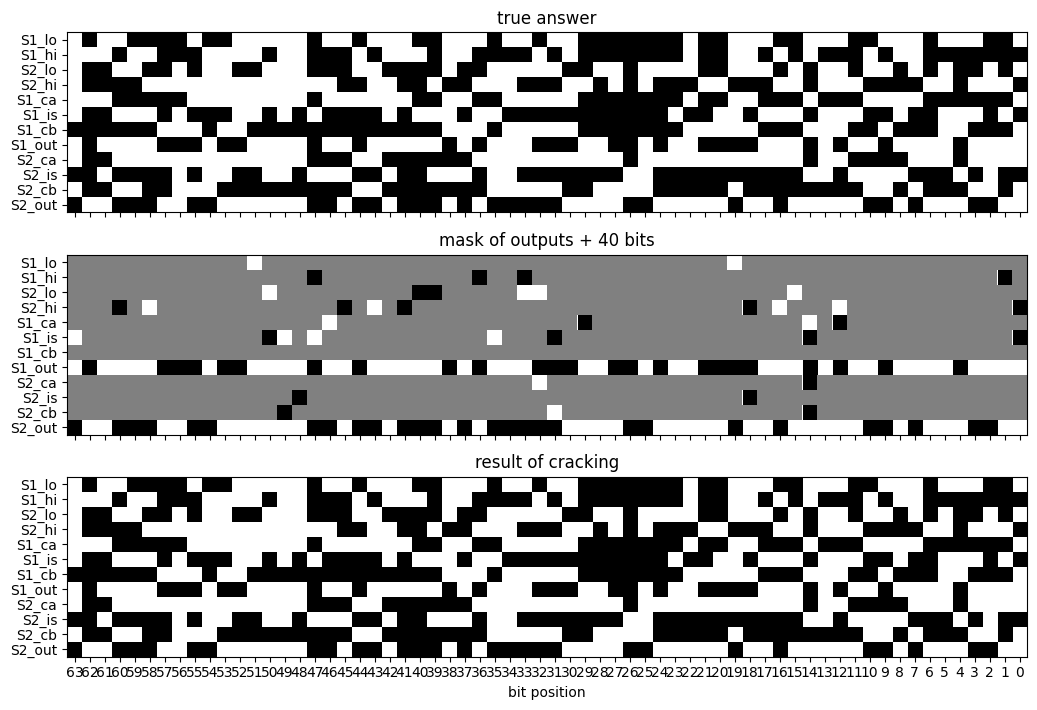

In [46]:
plot_stacked_arrays([
    truevals.reshape((-1,64)),
    datawithguesses.reshape((-1,64)),
    cracked.reshape((-1,64)),
],
                   row_labels=roworder,
                   titles=[
                       'true answer',
                       f'mask of outputs + {int(bestvect.sum() - 64*2)} bits',
                       'result of cracking',
                   ])